<a href="https://colab.research.google.com/github/Sjoerd-de-Witte/Machine-Learning-2023/blob/main/3_6_Kaggle_Heart_Disease_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!gdown -O /tmp/ml.py 174lBNvDBJSVWs3OpNL3a68cnhWIcWYuY
%run /tmp/ml.py

Downloading...
From: https://drive.google.com/uc?id=174lBNvDBJSVWs3OpNL3a68cnhWIcWYuY
To: /tmp/ml.py
100% 1.31k/1.31k [00:00<00:00, 4.34MB/s]


# Kaggle Heart Disease

Participate in the Kaggle Heart Disease Binary Classification challenge: https://www.kaggle.com/c/mlms1/overview

Train and validate two different classification models. You can choose which, for example Logistic Regression, SVM, Decision Tree, kNN, Random Forest, ... and make sure you apply validation to make sure the model is working as expected (not underfitting or overfitting) and have your hyperparameters tuned. It appears that accuracy is used as the metric to optimize for this competition, so evaluate the models and choose the best performing model to submit to Kaggle.

In [3]:
from pipetorch import DFrame
from pipetorch.evaluate.study import Study
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

You can use the code below to load the training set for this task. The target variable is called 'target'.

In [4]:
df = DFrame.read_from_kaggle('mlms1', 'train.csv', 'test_set.csv')

# Test set

Kaggle competitions usually have separate train and test files. The test.csv does not contain a ground truth to avoid cheating. You should split the train file into a train/valid part allowing to optimize the generalization of the model (after all, you want to perform optimally on the test set). You should do all optimization on the train/valid split without peeking at the test set. Then when you are satisfied, exactly replicate all preprocessing to the test set, compute the scores and submit these to Kaggle to see how well you did.

PipeTorch will make life a bit easier. The train and test parts are combined in one DataFrame, so that any preprocessing on the train set is automatically replicated on the valid and test set. The valid and test set are always kept isolated though, so any statistic used for scaling, balancing, handling categorical variables will be based solely on the train set, you do not have to worry about leaking test data. Do be careful that dropping rows with missing values will affect the test set (and that is probably not what you want). You can address these subsets as `df.train`, `df.valid` and `df.test`. You should not peek at the test set, and only use it to generate results when the model is final.

# Feature selection

Previously, we have simply selected features in the dataset by slicing. In this case, we want to keep the `id` to submit results. To use all other features except the target variable(s) and `id`, you can use `columnx` with an `omit=True` on the `id`. This will keep the column in the DataFrame, but not use it in training.

In [9]:
df = df.columny('target').columnx('id', omit=True).split(valid_size=0.3)

# Prepare the data

I this case, you may not want to slice out the columns you do not use. When we submit the results to Kaggle, we need the `Id`'s of these houses, but we do not want to use that as an input feature. You can use `columnx()` and `columny()` to keep all columns, but use only those features in your experiment. You can also invert the feature selection by using `columnx(omit=True)` and the target variables are omitted by default.

In [10]:
# balance and scale the data

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(df.train_X)
train_X = scale.transform(df.train_X)
valid_X = scale.transform(df.valid_X)

# Learn an optimal classifier

(e.g. SVM, decision tree, ...) and validate the model (tune the hyperparameters)

In [11]:
study = Study.create_study('accuracy')

def trial(trial):
    degree = trial.suggest_categorical('depth',list(range(10,150,5)))
    model = RandomForestClassifier(max_depth=degree)
    model.fit(train_X, df.train_y)

    pred_y = model.predict(train_X)
    accuracy_train = accuracy_score(df.train_y, pred_y)

    pred_y = model.predict(valid_X)
    accuracy_valid = accuracy_score(df.valid_y, pred_y)

    return accuracy_valid

study.optimize(trial, n_trials = 100)

[I 2023-10-03 10:35:57,082] A new study created in memory with name: no-name-6b0222de-9c74-4d13-bd1f-e29bc9f1fd0f
[I 2023-10-03 10:35:57,381] Trial 0 finished with value: 0.9285714285714286 and parameters: {'depth': 55}. Best is trial 0 with value: 0.9285714285714286.
[I 2023-10-03 10:35:57,858] Trial 1 finished with value: 0.8571428571428571 and parameters: {'depth': 135}. Best is trial 0 with value: 0.9285714285714286.
[I 2023-10-03 10:35:58,183] Trial 2 finished with value: 0.8571428571428571 and parameters: {'depth': 95}. Best is trial 0 with value: 0.9285714285714286.
[I 2023-10-03 10:35:58,542] Trial 3 finished with value: 0.7857142857142857 and parameters: {'depth': 125}. Best is trial 0 with value: 0.9285714285714286.
[I 2023-10-03 10:35:58,879] Trial 4 finished with value: 1.0 and parameters: {'depth': 15}. Best is trial 4 with value: 1.0.
[I 2023-10-03 10:35:59,222] Trial 5 finished with value: 0.8571428571428571 and parameters: {'depth': 70}. Best is trial 4 with value: 1.0.

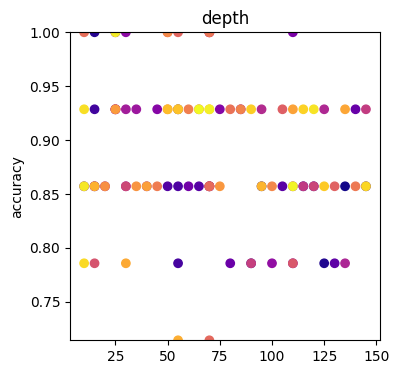

In [12]:
# plot the hyperparameters
study.plot_hyperparameters()

# Learn another classifier

(e.g. Logistic Regression) and validate the model

In [13]:
lr = LogisticRegression()
lr.fit(df.train_X, df.train_y)
pred_y = lr.predict(df.valid_X)
print(accuracy_score(df.valid_y, pred_y))

0.7857142857142857


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Compare the accuracy of these two models

# Submission

To submit you results, you have to create a .csv file for the test set. You can follow these steps. You can generate predictions on the test set the same way you do for the train and valid set. You can fill in these results in the target variable column of the test set and use the .to_csv to export what is needed to a .csv file.

In [14]:
# generate predictions of the model that was trained on the training set
# do not learn a new model here!
y_pred = lr.predict(df.test_X)

In [15]:
# add the predictions as a new column SalePrice
results = df.test.add_column(y_pred, 'target')

In [16]:
results = results[['id', 'target']]

In [17]:
# the competition requires that you create a .csv file to submit
# have not tested this, but this should work
results.to_csv('heart_disease_results.csv', index=False, header=True)

In [18]:
results

,id,target
45,49,0.0
46,36,0.0
47,171,1.0
48,10,1.0
49,291,0.0
...,...,...
292,127,1.0
293,166,1.0
294,281,0.0
295,76,0.0


After running the last cell, you can find and download your .csv file in Jupyter's file list. Submit it to see what your score is on the leaderboard!!!

In [ ]:
halt_notebook()